<a href="https://colab.research.google.com/github/dforteza/CIFAR-100/blob/main/cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pickle
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize

import seaborn as sns
import cv2

#Introdución al Problema



En el presente trabajo se propone la creación de un modelo de red neuronal convolucional (CNN) para la clasificación de imágenes en 100 categorías. El conjunto de datos utilizado será el CIFAR-100, que consta de 600 imágenes de 32x32 píxeles por categoría, con un total de 60.000 imágenes de entrenamiento y 10.000 imágenes de prueba.
El objetivo del trabajo es diseñar un modelo que sea capaz de alcanzar la mayor precisión posible en los datos de prueba. Para ello, se seguirá un enfoque metodológico basado en la construcción de un modelo base y su posterior mejora mediante la incorporación de nuevos componentes o la modificación de los parámetros existentes.
En la primera parte del trabajo se realizará una descripción del conjunto de datos CIFAR-100, así como una introducción a las CNN. En la segunda parte se presentará la metodología seguida para el diseño y entrenamiento del modelo. En la tercera parte se mostrarán los resultados obtenidos y se realizarán algunas reflexiones sobre las posibles mejoras que podrían aplicarse al modelo.

**DESCRIPCIÓN DEL CONJUNTO DE DATOS**

El conjunto de datos CIFAR-100 (Instituto Canadiense de Investigación Avanzada, 100 clases) es un subconjunto del conjunto de datos Tiny Images y consta de 60000 imágenes en color de 32x32. Las 100 clases del CIFAR-100 se agrupan en 20 superclases. Hay 600 imágenes por clase. Cada imagen viene con una etiqueta "fina" (la clase a la que pertenece) y una etiqueta "gruesa" (la superclase a la que pertenece). Hay 500 imágenes de entrenamiento y 100 imágenes de prueba por clase.


En primer lugar, se carga la base de datos con los datos mencionados.

In [4]:
# Descargamos la base de datos
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar100.load_data()

# Tamaño de los conuntos
print(f"x_train shape: {train_data.shape}")
print(f"y_train shape: {train_labels.shape}")
print(f"x_test shape: {test_data.shape}")
print(f"y_test shape: {test_labels.shape}")

# Número de muestras
print(f"Train: {train_data.shape[0]}")
print(f"Test: {test_data.shape[0]}")

# Data format
print(type(train_data))
print(type(train_labels))

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Train: 50000
Test: 10000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


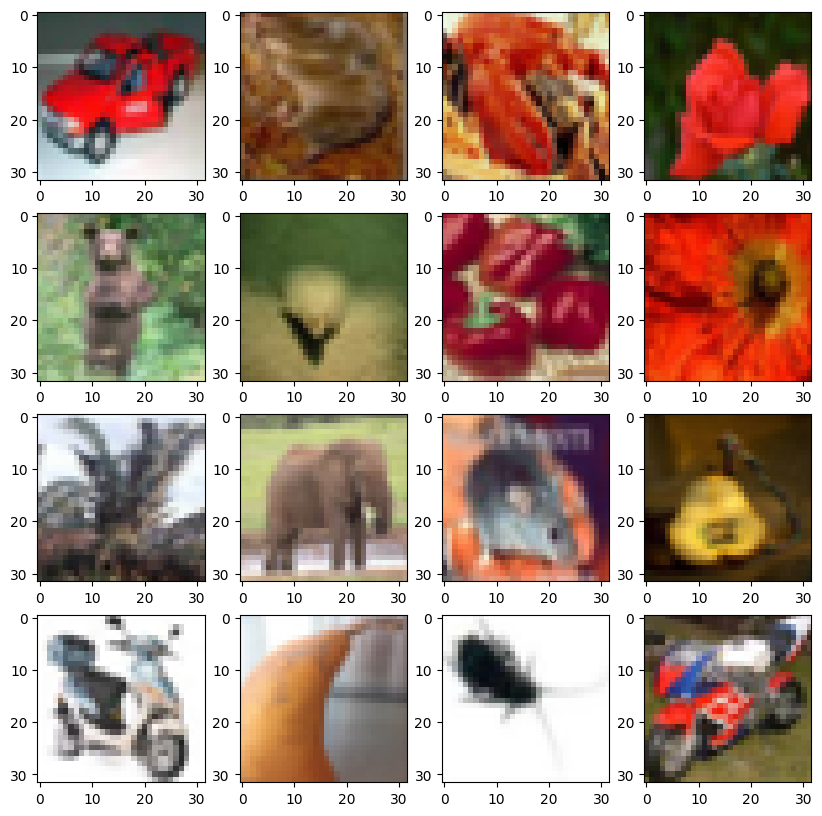

In [5]:
# Show randomly 16 images in the CIFAR-100
plt.figure(figsize=(10, 10))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(train_data[rand_num])

##Preprocesamiento de los datos

In [6]:
from keras.utils import to_categorical

train_data = train_data.astype('float32')/255
test_data = test_data.astype('float32')/255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [7]:
from sklearn.model_selection import train_test_split

# Split: Divide los datos de entrenamiento en entrenamiento y validación con razón de 80/20
train_x, val_x, train_y, val_y = train_test_split(train_data, train_labels,
                                                  test_size = 0.2,
                                                  random_state = 123) # para que la partición siempre sea de la misma manera

In [8]:
# Se definen variables que van a contener los resultados de los entrenamientos
HISTORY = []
TEST_LOSS = []
TEST_ACC = []

In [43]:
# Se definen las funciones auxiliares a utilizar durante el desarrollo de la practica

# Gráfica la pérdida y precisión del modelo seleccionado
def training_plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

# Curvas de aprendizaje
"""
Notas: Los elementos de HISTORY son diccionarios que contienen los nombres de las métricas como claves
y sus valores (.values()) son listas con los valores de las métricas durante el entrenamiento model.fit
"""
import matplotlib.pyplot as plt

def curvas_aprendizaje(HISTORY, nfilas, ncol, size = (18,10), title = []):
    # Función para imprimir las curvas de aprendizaje en una rejilla de nfilas x ncol
    # Argumentos: HISTORY = Lista con variables history de keras (obtenidas de model.fit)
    #        nfilas, ncol = Nº de filas y columnas de la rejilla
    #                size = Tamaño total de la rejilla (por defecto es (18,10))
    # !Importante: El nº total de filas x col debe ser superiror al de los elementos pasados como argumento en HISTORY
    if len(HISTORY) > nfilas*ncol:
        print("Error. Dimensiones incompatibles")
        return 0
    else:
        fig = plt.figure(figsize=size) # Especifica tamaño de la figura

        for i, registro in enumerate(HISTORY):

            plt.subplot(nfilas, ncol, i+1) # Añade subplot (gráfica para un modelo)
            if title:
              plt.title(title[i])
            else:
              plt.title("Modelo " + str(i+1)) # Formato de cada gráfica
            plt.xlabel('Épocas')
            plt.ylim((0,2))

            acc = registro.history['accuracy']
            loss = registro.history['loss']

            x = list(range(1, len(acc) + 1))

            plt.plot(x, loss, 'o-') # Imprime
            plt.plot(x, acc, 'o-')


            plt.xticks([])

            plt.legend(list(registro.history.keys()))
            plt.text(len(x), loss[len(loss)-1], str(round(loss[len(loss)-1],3))) # Valor punto final  loss
            plt.text(len(x), acc[len(acc)-1], str(round(acc[len(acc)-1],3))) # Valor punto final  accuracy

    fig.tight_layout()
    plt.show()

# Gráfico de barras horizontales
def testerror_testacc(ERROR, ACC, titles, size = (12,12)):
    fig = plt.figure(figsize=size) # Especifica tamaño de la figura

    # Ordena pérdida en orden ascendente y precisión en orden descendente
    sorted_err = dict(zip(titles, ERROR))
    sorted_err = dict(sorted(sorted_err.items(), key = lambda x: x[1], reverse=True))

    sorted_acc = dict(zip(titles, ACC))
    sorted_acc = dict(sorted(sorted_acc.items(), key = lambda x: x[1]))

    # Gráfica
    plt.subplot(1, 2, 1)
    plt.barh(list(sorted_err.keys()), list(sorted_err.values()))
    plt.title('Test error')

    plt.subplot(1,2,2)
    plt.barh(list(sorted_acc.keys()), list(sorted_acc.values()), color='orange')
    plt.title('Test accuracy')

    fig.tight_layout()
    plt.show()

Medida del Éxito

Con la intención de evaluar el resultado de los diferentes modelos se definen los siguientes indicadores de servicio, que se aplicarán a todos los modelos utilizados en igualdad de condiciones. Los indicadores de servicio se denominan también "Key Performance Indicator"(KPI) y su cálculo permite una valoración objetiva de cada modelo utilizado.

El primer indicador de servicio propuesto es la precisión obtenida con los datos de test. Esta medida nos otorgará la eficiencia en la identificación de las subclases con imágenes nunca antes vistas. Su fórmula viene dada por:



```
Accuracy = True Positive / (True Positive + False Positive)
```



El segundo indicador a considerar es el tiempo de ejecución en igualdad de condiciones de uds. de procesamiento (4 GPUs). El tiempo de ejecución sobre las mismas capacidades de procesamiento es proporcional a la complejidad de los modelos.

#Modelos

Para comparar la mejora del rendimiento en función de los cambios aplicados a un modelo que llamaremos modelo base o de referencia se obtendrán los KPIs definidos anteriormente.

La evolución de los modelos pretende ser progresiva desde el modelo base que es el más simple. A continuación se evaluará el modelo base introduciendo la técnica de *"Data Augmentation"*  con el objetivo de incrementar el volumen de datos de aprendizaje con los datos de entrenamiento. Por último, se aplicará un modelo optimizado utilizando de nuevo *"Data Agumentation"*

##Modelo Base

El modelo base consta de 13.870.484 párametros entrenables y está formado por 3 pilas de capas convolucionales con función de activación Relu seguidas cada una de ellas por una capa de pooling, 2 capas densas con función de activación Relu y una última capa densa con función de activación softmax. Esta última se corresponde con la capa de salida.

A continuación se muestra un esquema de la red:

*   Capa de entrada
*   [CONV -> RELU] x 2
*   MAX POOL
*   [CONV -> RELU] x 2
*   MAX POOL
*   [CONV -> RELU] x 2
*   MAX POOL
*   FLATTEN
*   [DENSE -> RELU] x 2
*   [DENSE -> SOFTMAX] -> Capa de salida


Las especificaciones de los parámetros utilizados en la construcción del modelo se muestran a continuación:

1.   En cada capa convolucional se utiliza `padding = "same"`, es decir, se añadan tantas filas y columnas de ceros para que la salida tenga la misma dimensión que la entrada para preservar el tamaño espacial.
2.   Se utiliza ReLU en las capas convolucionales debido a su eficiencia en rendimiento en términos de precisión por encima de otras funciones de activación probadas (sigmoid y tang).
3.   Se ha utilizado un kernel size de 3x3 para todas las capas convolucionales ya que se quería extraer la mayoría de los detalles de las imágenes.
4.   Max pool de tamaño 2x2 ha ofrecido mejores rendimientos que otras opciones como average pool o global pool. Además utilizar un stride de tamaño 2 nos ha permitido obtener un balance entre rendimiento y precisión.
5.   El número de filtros utilizados en la primera pila de
capas convolucionales es 128, 256 y 512 para la tercera. La obtención de estos parámetros empezó desde 32, 64 y 128 y fue incrementandose gradualmente hasta los resultados obtenidos.
6.   Tres capas completamente conectadas con 1000 unidades en las dos primeras capas y 100 unidades (unidades iguales a la número de clases) en la última capa (de salida) han sido utilizadas para hacer que la red sea densa y aprenda las características obtenidas del proceso convolucional. Esta combinación de unidades y capas ayudó a que la red clasificara imágenes con más precisión (5% más) que la red con sólo dos capas completamente conectadas.










In [10]:
#Modelo base
model_ba= Sequential()

#Capa 1
#convolucion
model_ba.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=(32,32,3)))
model_ba.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
#pooling
model_ba.add(MaxPool2D(pool_size=2, strides=2))

#Capa 2
#convolucion
model_ba.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model_ba.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
#pooling
model_ba.add(MaxPool2D(pool_size=2, strides=2))

#Capa 3
#convolution
model_ba.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model_ba.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model_ba.add(MaxPool2D(pool_size=2, strides=2))

#flattening
model_ba.add(Flatten())

#1º capa densa
model_ba.add(Dense(units=1000, activation="relu"))
#2º capa densa
model_ba.add(Dense(units=1000, activation="relu"))

#capa de salida
model_ba.add(Dense(units=100, activation="softmax"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model_ba.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     8,193,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       100,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,870,484 (52.91 MB)

 Trainable params: 13,870,484 (52.91 MB)

 Non-trainable params: 0 (0.00 B)

Debido a la restricción del entorno de ejecución Google Colab en memoria se ha entrenado el modelo durante 100 épocas manteniendo un `batch_size = 64`. Remarcar que un batch_size de 32 ofrecía una pequeña mejora en el rendimiento en cuanto a precisión pero un incremento de tiempo de ejecución más elvado.

Para la elcción del **optimizador** se han comparado los optimizadores RMSProp, Adam y Nadam con distintas tasas de aprendizaje (0.01, 0,001, 0.0001 y 0.00001) y atendiendo a la precisión obtenida por el modelo base con cada uno de los casos se elige la opción Nadam con `learning rate' = 0.0001`.

In [12]:
epochs = 100
batch_size = 64
optimizer_ba = keras.optimizers.Nadam(learning_rate=0.0001)

model_ba.compile(optimizer=optimizer_ba, loss='categorical_crossentropy', metrics=['accuracy'])

El uso de los callbacks `EarlyStopping()` y `ModelCheckpoint()` permite guardar el modelo óptimo sin desperdiciar recursos de memoria. Para ello se establece como valor de rendimiento la pérdida con los datos de validación con la intención de evitar el sobreentrenamiento y se le da una paciencia de 20.
La paciencia establece los grados de libertad de decidir cuando detener el entrenamiento, en este caso, si la pérdida con los datos de validación empeora durante 20 épocas.



In [13]:
early_stop_ba = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

model_checkpoint_ba = ModelCheckpoint('Checkpoint_BaseModel.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [14]:
# Entrenamiento del modelo
import time
training_start = time.time()
history_ba = model_ba.fit(train_x, train_y,
                      batch_size= batch_size,
                      epochs=epochs,
                      validation_data = (val_x, val_y),
                      callbacks=[early_stop_ba, model_checkpoint_ba],
                      verbose = 1)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0518 - loss: 4.2450
Epoch 1: val_loss improved from inf to 3.46058, saving model to Checkpoint_BaseModel.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - accuracy: 0.0519 - loss: 4.2441 - val_accuracy: 0.1711 - val_loss: 3.4606
Epoch 2/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2026 - loss: 3.2946
Epoch 2: val_loss improved from 3.46058 to 2.97551, saving model to Checkpoint_BaseModel.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.2027 - loss: 3.2942 - val_accuracy: 0.2694 - val_loss: 2.9755
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3123 - loss: 2.7507
Epoch 3: val_loss improved from 2.97551 to 2.69010, saving model to Checkpoint_BaseModel.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.3123 - loss: 2.7506 - val_accuracy: 0.3274 - val_loss: 2.6901
Epoch 4/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4049 - loss: 2.3129
Epoch 4: val_loss improved from 2.69010 to 2.57520, saving model to Checkpoint_BaseModel.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.4049 - loss: 2.3128 - val_accuracy: 0.3579 - val_loss: 2.5752
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4956 - loss: 1.8959
Epoch 5: val_loss improved from 2.57520 to 2.51392, saving model to Checkpoint_BaseModel.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.4956 - loss: 1.8959 - val_accuracy: 0.3759 - val_loss: 2.5139
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6074 - loss: 1.4327
Epoch 6: val_loss did not improve from 2.51392
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.6074 - loss: 1.4327 - val_accuracy: 0.3811 - val_loss: 2.6638
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7404 - loss: 0.9212
Epoch 7: val_loss did not improve from 2.51392
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.7404 - loss: 0.9213 - val_accuracy: 0.3728 - val_loss: 2.9598
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8580 - loss: 0.4880
Epoch 8: val_loss did not improve from 2.51392
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.8580 - loss: 0.4880 - val_accuracy: 0.3603 - val_loss: 3.5850
Epoch 9/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9271 - loss: 0.2421
Epoch 9: val_loss did not impro

In [15]:
HISTORY.append(history_ba)

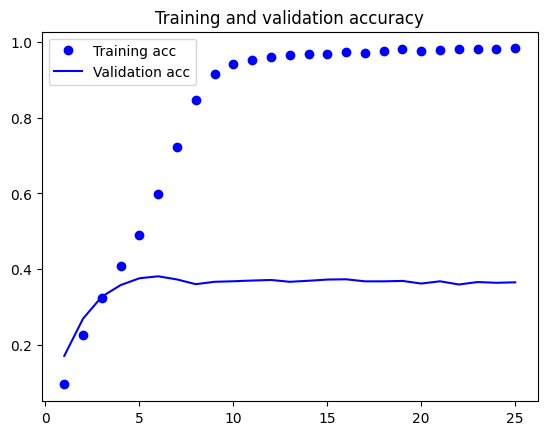

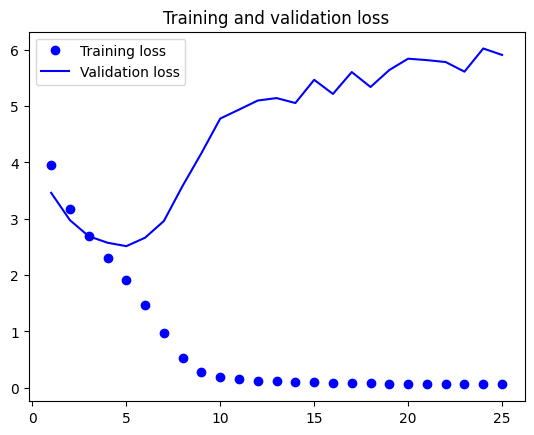

In [16]:
training_plot(history_ba)

Tras entrenar el modelo se observa que antes de la epoch 20 el modelo ha obtenido con los datos de entrenamiento una precisión próxima a la máxima. Además a partir de la gráfica de pérdida se observa que el modelo empieza a sobreentrenar demasiado rápido.

Todo esto significa que el modelo se está acoplando demasiado rápido a los datos de entrenamiento y no esta permitiendo converjer con los datos de validación.

####Rendimiento

In [17]:
scores_ba = model_ba.evaluate(test_data, test_labels)
TEST_LOSS.append(scores_ba[0])
TEST_ACC.append(scores_ba[1])
print(f'accuracy on test set: {model_ba.metrics_names[1]} of {scores_ba[1]*100}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3844 - loss: 5.6691
accuracy on test set: compile_metrics of 37.950000166893005


Con los datos anteriormente descritos se obtienen los siguientes valores:
*   Tiempo de ejecución: ~644 s en 25 epochs.
*   Precisión con los datos de test: ~37%



##Modelo Base con Data Augmentation

###Data Augmentation

Uno de los principales problemas para la convergencia de cualquier modelo con esta base de datos es la escasez de imágenes por clase en la base de datos (50.000 imágenes repartidas en 100 clases da lugar a 500 imágenes por clase). Para paliar este problema se podría aumentar el número de imágenes or clase añadiendo más pero esto supondría un problema debido a la limitación de memoria establecida por Google Colab. Con estos antecedentes se presenta la técnica DataAugmentation mediante Keras ImageDataGenerator.

 Keras ImageDataGenerator es una técnica que permite aumentar tu número de imágenes en tiempo real mientras tu modelo aún se está entrenando sin suponer un coste de memoria adicional. Consiste en la aplicación de transformaciones sobre las imágenes tales como: rotaciones y traslaciones, aumento y disminución de brillo y zoom entre otras. De esta manera se consiguen datos sintéticos para mejorar el entrenamiento del modelo.

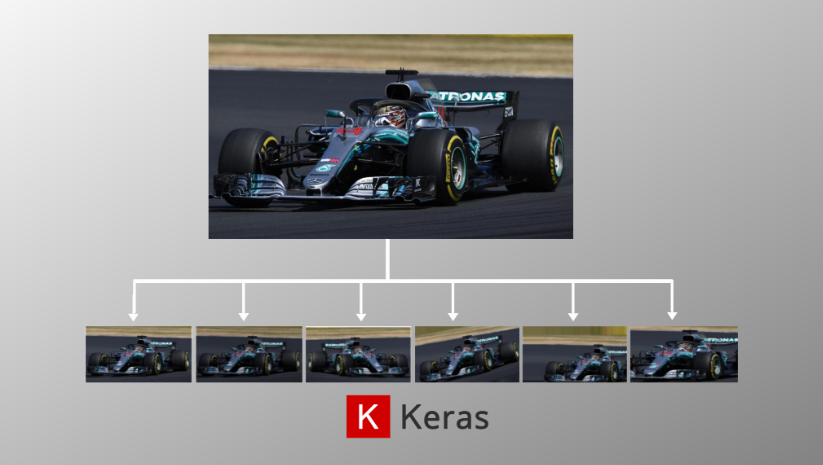

###Modelo

In [18]:
#Modelo base
model_DA= Sequential()

#Capa 1
#convolucion
model_DA.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=(32,32,3)))
model_DA.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
#pooling
model_DA.add(MaxPool2D(pool_size=2, strides=2))

#Capa 2
#convolucion
model_DA.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model_DA.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
#pooling
model_DA.add(MaxPool2D(pool_size=2, strides=2))

#Capa 3
#convolution
model_DA.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model_DA.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model_DA.add(MaxPool2D(pool_size=2, strides=2))

#flattening
model_DA.add(Flatten())

#1º capa densa
model_DA.add(Dense(units=1000, activation="relu"))
#2º capa densa
model_DA.add(Dense(units=1000, activation="relu"))

#capa de salida
model_DA.add(Dense(units=100, activation="softmax"))

In [19]:
model_DA.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     8,193,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │       100,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,870,484 (52.91 MB)

 Trainable params: 13,870,484 (52.91 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
optimizer_DA = keras.optimizers.Nadam(learning_rate=0.0001)

model_DA.compile(optimizer=optimizer_DA, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop_DA = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#saving the model checkpoint for the best model
model_checkpoint_DA = ModelCheckpoint('CheckPoint_DataAug.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

Se aplica una el parámetro rotation_range para provocar una rotación de 20º y horizontal flip para voltear la imagen a lo largo del eje horizontal. Estos cambios se aplican a todas las imágenes de entrenamiento.

In [22]:
data_gen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)

data_gen.fit(train_x, seed = 123)

In [23]:
# Entrenamiento del modelo
import time
history_DA = model_DA.fit(data_gen.flow(train_x,train_y,
                    batch_size=batch_size,
                    seed=123),
                    epochs=epochs,
                    steps_per_epoch=train_x.shape[0] // batch_size,
                    validation_data=(val_x, val_y),
                    callbacks=[early_stop_DA, model_checkpoint_DA],
                    verbose=1)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0522 - loss: 4.2428
Epoch 1: val_loss improved from inf to 3.53851, saving model to CheckPoint_DataAug.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step - accuracy: 0.0523 - loss: 4.2424 - val_accuracy: 0.1647 - val_loss: 3.5385
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1883 - loss: 3.3768
Epoch 2: val_loss improved from 3.53851 to 3.06328, saving model to CheckPoint_DataAug.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.1883 - loss: 3.3767 - val_accuracy: 0.2554 - val_loss: 3.0633
Epoch 3/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2699 - loss: 2.9260
Epoch 3: val_loss improved from 3.06328 to 2.78521, saving model to CheckPoint_DataAug.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.2699 - loss: 2.9258 - val_accuracy: 0.3083 - val_loss: 2.7852
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3349 - loss: 2.6132
Epoch 4: val_loss improved from 2.78521 to 2.60635, saving model to CheckPoint_DataAug.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.3349 - loss: 2.6132 - val_accuracy: 0.3477 - val_loss: 2.6064
Epoch 5/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3927 - loss: 2.3341
Epoch 5: val_loss improved from 2.60635 to 2.48663, saving model to CheckPoint_DataAug.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.3927 - loss: 2.3340 - val_accuracy: 0.3695 - val_loss: 2.4866
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4455 - loss: 2.1144
Epoch 6: val_loss improved from 2.48663 to 2.37927, saving model to CheckPoint_DataAug.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.4455 - loss: 2.1144 - val_accuracy: 0.3928 - val_loss: 2.3793
Epoch 7/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4895 - loss: 1.9059
Epoch 7: val_loss did not improve from 2.37927
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.4895 - loss: 1.9059 - val_accuracy: 0.3993 - val_loss: 2.4007
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5384 - loss: 1.7106
Epoch 8: val_loss improved from 2.37927 to 2.30889, saving model to CheckPoint_DataAug.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.5384 - loss: 1.7107 - val_accuracy: 0.4224 - val_loss: 2.3089
Epoch 9/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5886 - loss: 1.4953
Epoch 9: val_loss did not improve from 2.30889
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.5886 - loss: 1.4954 - val_accuracy: 0.4142 - val_loss: 2.4444
Epoch 10/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6383 - loss: 1.3077
Epoch 10: val_loss did not improve from 2.30889
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.6382 - loss: 1.3078 - val_accuracy: 0.4194 - val_loss: 2.4915
Epoch 11/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6812 - loss: 1.1212
Epoch 11: val_loss did not improve from 2.30889
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.6812 - loss: 1.1213 - val_accuracy: 0.4220 - val_loss: 2.5402
Epoch 12/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7248 - loss: 0.9610
Epoch 12: val_loss did not

In [24]:
HISTORY.append(history_DA)

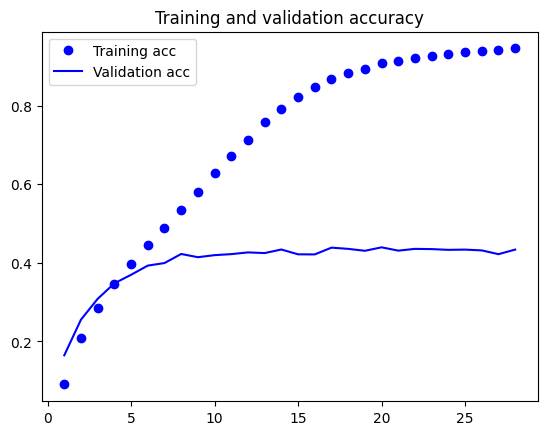

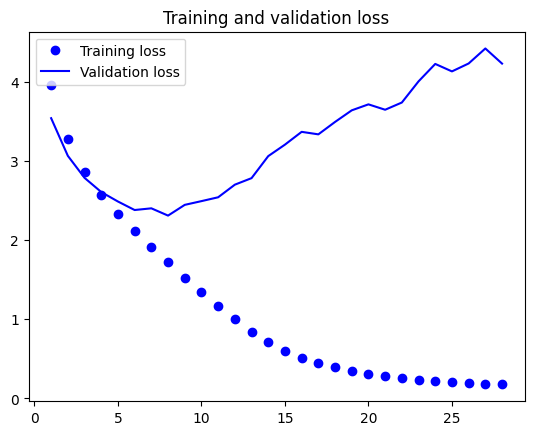

In [25]:
# Visualize training process
training_plot(history_DA)

De las gráficas se observa que el modelo, a partir de la época 20, obtiene una precisión elevada (o una pérdida muy baja) con los datos de entrenamiento. A parte, de los datos de validación se observa que el modelo converje hacia una precisión del ~40% y que antes de la época 10 el modelo vuelve a sobreentrenar.

Todo esto significa que el modelo se está acoplando demasiado rápido a los datos de entrenamiento y no esta permitiendo converjer adecuadamente con los datos de validación.

####Rendimiento

In [26]:
scores_DA = model_DA.evaluate(test_data, test_labels)
TEST_LOSS.append(scores_DA[0])
TEST_ACC.append(scores_DA[1])

print(f'accuracy on test set: {model_DA.metrics_names[1]} of {scores_DA[1]*100}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4410 - loss: 4.1875
accuracy on test set: compile_metrics of 44.3699985742569


Con los datos anteriormente descritos se obtienen los siguientes valores:
*   Tiempo de ejecución: ~1627 s en 26 epochs.
*   Precisión con los datos de test: ~44%



##Modelo Optimizado con Data Augmentation

###Optimizadores

**Dropout** se utiliza como una técnica de regularización cuyo objetivo es evitar el sobreajuste al garantizar que ninguna unidad sea codependiente.

Consiste en consiste en retirar (poner a cero) aleatoriamente un número de características de salida de la capa durante el entrenamiento. En cada epoch cada neurona tiene una tasa o probabilidad de estar inactiva. La “tasa de dropout” es la fracción de características que se ponen a 0 (entre 0.2 a 0.5).

**Batch Normalization** es uno de los métodos diseñados para evitar problemas en el descenso estocástico del gradiente a través de la normalización de los inputs de las capas y su posterior transformación. Para ello Batch Normalization actúa como una capa donde realiza 2 acciones:

Normaliza los valores introducidos.

zi=γ⊗x^i+β  donde

γ  es un factor escalar (inicializado como 1).

β  es un factor de compensación (inicializado como 0).

Ventajas:

*   Vuelve la red más rápida y estable
*   Se logra mayor precisión en la red en menos epochs lo que puede desembocar en un mayor rendimiento de este si se mantiene el número inicial de epochs.

El **Dropout** se ha utilizado en todas las capas con valor de 0.2 en la capa de entrada y 0.5 en el resto de capas. La configuración configuración de 0.2 y 0,5 funcionó bien y fue
También es computacionalmente eficiente.

La elección de dropout con valor de 0.2 en la primera capa convolucional es debido a que al usar un valor de 0.5 el modelo obtiene menos precisión. Esto se debe a que al suprimir la mitad de parámetros en la primera capa estamos impidiendo que se traslade toda la información de forma adecuada.

NOTA:


###Modelo

In [27]:
#initializing CNN model
model_op = Sequential()

#Stack 1
#convolution
model_op.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=(32,32,3)))
model_op.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
#pooling
model_op.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model_op.add(Dropout(0.2))

#Stack 2
#convolution
model_op.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model_op.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
#pooling
model_op.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model_op.add(Dropout(0.5))

#Stack 3
#convolution
model_op.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model_op.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model_op.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model_op.add(Dropout(0.5))

#flattening
model_op.add(Flatten())

#full connection
model_op.add(Dense(units=1000, activation="relu"))
#dropout
model_op.add(Dropout(0.5))

#full connection
model_op.add(Dense(units=1000, activation="relu"))
#dropout
model_op.add(Dropout(0.5))

#output layer
model_op.add(Dense(units=100, activation="softmax"))

**Explicación suma de parámetros**
La capa convolucional va recorriendo la imagen en ventanas de 3x3 creando así una capa oculta de 26x26 (28 píxeles - 3 de las ventanas + 1 de la primera iteración = 26) y un padding de "same" para preservar las dimensiones de la imagen original. El cálculo de parámetros se hará con la siguiente fórmula: parámetros = (tamaño del kernel(largo) x tamaño del kernel(ancho) x número de canales de entrada + 1) x número de filtros. Con esta fórmula nuestra primera capa convolucional tendrá los siguientes parámetros: (3 x 3 x 3 + 1) x 128 = 3584.
Nuestra segunda capa convolucional tendrá la siguiente cantidad de parámetros: (3 x 3 x 128(número de canales de entrada proveniente de la capa anterior) + 1) x 128 = 147584.
La tercera tendrá: (3 x 3 x 128 + 1) x 256 = 295168.
La cuarta tendrá: (3 x 3 x 256 + 1) x 256 = 590080.
La quinta tendrá: (3 x 3 x 256 + 1) x 512 = 1180160.
La sexta tendrá: (3 x 3 x 512 + 1) x 512 = 2359808.
Para el calculo de parámetros de la capa densa seguiremos la siguiente fórmula: Parámetros=(Entradas + 1) × neuronas. En nuestro caso será: (8192 + 1) x 1000 = 8193000. Para nuestra segunda capa densa el cálculo será:  (1000 + 1) x 1000 = 1001000. Para nuestra tercera capa densa el cálculo será: (1001 + 1) x 100 = 100100. El resultado total de los parámetros será la suma de lo calculado anteriormente.

In [28]:
model_op.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1000)           │     8,193,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       100,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,870,484 (52.91 MB)

 Trainable params: 13,870,484 (52.91 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
epochs_op = 100
batch_size_op = 64
optimizer_op = keras.optimizers.Adam(learning_rate=0.0001)

model_op.compile(optimizer=optimizer_op, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
early_stop_op = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

model_checkpoint_op = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [31]:
#Aumento de las imagenes de entrenamiento
data_gen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)

In [32]:
data_gen.fit(train_x, seed = 123)

In [33]:
import time
history_op = model_op.fit(data_gen.flow(train_x,train_y,
                    batch_size=batch_size_op,
                    seed=123),
                    epochs=epochs_op,
                    steps_per_epoch=train_x.shape[0] // batch_size,
                    validation_data=(val_x, val_y),
                    callbacks=[early_stop_op, model_checkpoint_op],
                    verbose=1)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0119 - loss: 4.5830
Epoch 1: val_loss improved from inf to 4.27677, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - accuracy: 0.0119 - loss: 4.5829 - val_accuracy: 0.0384 - val_loss: 4.2768
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0398 - loss: 4.2516
Epoch 2: val_loss improved from 4.27677 to 4.02955, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.0398 - loss: 4.2516 - val_accuracy: 0.0883 - val_loss: 4.0296
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0742 - loss: 3.9920
Epoch 3: val_loss improved from 4.02955 to 3.70089, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.0742 - loss: 3.9919 - val_accuracy: 0.1310 - val_loss: 3.7009
Epoch 4/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1111 - loss: 3.7621
Epoch 4: val_loss improved from 3.70089 to 3.38475, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.1112 - loss: 3.7619 - val_accuracy: 0.1826 - val_loss: 3.3847
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1488 - loss: 3.5559
Epoch 5: val_loss improved from 3.38475 to 3.19786, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.1488 - loss: 3.5558 - val_accuracy: 0.2134 - val_loss: 3.1979
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1810 - loss: 3.3619
Epoch 6: val_loss improved from 3.19786 to 3.03242, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.1810 - loss: 3.3618 - val_accuracy: 0.2467 - val_loss: 3.0324
Epoch 7/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2076 - loss: 3.2032
Epoch 7: val_loss improved from 3.03242 to 2.86213, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.2077 - loss: 3.2031 - val_accuracy: 0.2835 - val_loss: 2.8621
Epoch 8/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2352 - loss: 3.0582
Epoch 8: val_loss improved from 2.86213 to 2.74588, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.2352 - loss: 3.0581 - val_accuracy: 0.3056 - val_loss: 2.7459
Epoch 9/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2573 - loss: 2.9580
Epoch 9: val_loss improved from 2.74588 to 2.62992, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.2573 - loss: 2.9580 - val_accuracy: 0.3235 - val_loss: 2.6299
Epoch 10/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2796 - loss: 2.8410
Epoch 10: val_loss improved from 2.62992 to 2.59930, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.2796 - loss: 2.8409 - val_accuracy: 0.3327 - val_loss: 2.5993
Epoch 11/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3022 - loss: 2.7434
Epoch 11: val_loss improved from 2.59930 to 2.48887, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.3022 - loss: 2.7433 - val_accuracy: 0.3551 - val_loss: 2.4889
Epoch 12/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3193 - loss: 2.6449
Epoch 12: val_loss improved from 2.48887 to 2.40648, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.3193 - loss: 2.6449 - val_accuracy: 0.3730 - val_loss: 2.4065
Epoch 13/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3369 - loss: 2.5690
Epoch 13: val_loss improved from 2.40648 to 2.38945, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.3369 - loss: 2.5690 - val_accuracy: 0.3756 - val_loss: 2.3894
Epoch 14/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3532 - loss: 2.4854
Epoch 14: val_loss improved from 2.38945 to 2.22960, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.3532 - loss: 2.4854 - val_accuracy: 0.4070 - val_loss: 2.2296
Epoch 15/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3702 - loss: 2.4013
Epoch 15: val_loss improved from 2.22960 to 2.17851, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.3702 - loss: 2.4014 - val_accuracy: 0.4229 - val_loss: 2.1785
Epoch 16/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3831 - loss: 2.3539
Epoch 16: val_loss did not improve from 2.17851
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.3831 - loss: 2.3539 - val_accuracy: 0.4185 - val_loss: 2.2128
Epoch 17/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4000 - loss: 2.2741
Epoch 17: val_loss improved from 2.17851 to 2.11599, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.4000 - loss: 2.2741 - val_accuracy: 0.4357 - val_loss: 2.1160
Epoch 18/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4076 - loss: 2.2282
Epoch 18: val_loss improved from 2.11599 to 2.08174, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.4076 - loss: 2.2282 - val_accuracy: 0.4479 - val_loss: 2.0817
Epoch 19/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4319 - loss: 2.1444
Epoch 19: val_loss improved from 2.08174 to 2.00472, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.4319 - loss: 2.1445 - val_accuracy: 0.4605 - val_loss: 2.0047
Epoch 20/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4398 - loss: 2.1004
Epoch 20: val_loss improved from 2.00472 to 2.00349, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.4398 - loss: 2.1004 - val_accuracy: 0.4649 - val_loss: 2.0035
Epoch 21/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4435 - loss: 2.0649
Epoch 21: val_loss improved from 2.00349 to 1.92703, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.4435 - loss: 2.0649 - val_accuracy: 0.4806 - val_loss: 1.9270
Epoch 22/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4611 - loss: 2.0097
Epoch 22: val_loss improved from 1.92703 to 1.92144, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.4611 - loss: 2.0097 - val_accuracy: 0.4782 - val_loss: 1.9214
Epoch 23/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4657 - loss: 1.9472
Epoch 23: val_loss improved from 1.92144 to 1.90910, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.4657 - loss: 1.9473 - val_accuracy: 0.4868 - val_loss: 1.9091
Epoch 24/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4794 - loss: 1.9097
Epoch 24: val_loss improved from 1.90910 to 1.83232, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.4794 - loss: 1.9098 - val_accuracy: 0.4986 - val_loss: 1.8323
Epoch 25/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4880 - loss: 1.8836
Epoch 25: val_loss improved from 1.83232 to 1.81697, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.4880 - loss: 1.8836 - val_accuracy: 0.5079 - val_loss: 1.8170
Epoch 26/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4948 - loss: 1.8561
Epoch 26: val_loss did not improve from 1.81697
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.4949 - loss: 1.8561 - val_accuracy: 0.5009 - val_loss: 1.8540
Epoch 27/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5055 - loss: 1.8028
Epoch 27: val_loss improved from 1.81697 to 1.74267, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.5055 - loss: 1.8028 - val_accuracy: 0.5235 - val_loss: 1.7427
Epoch 28/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5163 - loss: 1.7676
Epoch 28: val_loss improved from 1.74267 to 1.73993, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.5163 - loss: 1.7676 - val_accuracy: 0.5244 - val_loss: 1.7399
Epoch 29/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5211 - loss: 1.7223
Epoch 29: val_loss did not improve from 1.73993
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.5211 - loss: 1.7223 - val_accuracy: 0.5078 - val_loss: 1.8292
Epoch 30/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5269 - loss: 1.7014
Epoch 30: val_loss improved from 1.73993 to 1.71735, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.5269 - loss: 1.7014 - val_accuracy: 0.5326 - val_loss: 1.7174
Epoch 31/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5388 - loss: 1.6712
Epoch 31: val_loss did not improve from 1.71735
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.5388 - loss: 1.6712 - val_accuracy: 0.5322 - val_loss: 1.7313
Epoch 32/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5428 - loss: 1.6392
Epoch 32: val_loss did not improve from 1.71735
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.5428 - loss: 1.6392 - val_accuracy: 0.5283 - val_loss: 1.7402
Epoch 33/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5542 - loss: 1.5848
Epoch 33: val_loss did not improve from 1.71735
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.5542 - loss: 1.5848 - val_accuracy: 0.5367 - val_loss: 1.7240
Epoch 34/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5532 - loss: 1.5961
Epoch 34: val_loss did n

625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.5694 - loss: 1.5379 - val_accuracy: 0.5461 - val_loss: 1.6328
Epoch 36/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5761 - loss: 1.5165
Epoch 36: val_loss did not improve from 1.63285
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.5761 - loss: 1.5165 - val_accuracy: 0.5506 - val_loss: 1.6393
Epoch 37/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5793 - loss: 1.4889
Epoch 37: val_loss did not improve from 1.63285
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.5793 - loss: 1.4889 - val_accuracy: 0.5472 - val_loss: 1.6697
Epoch 38/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5805 - loss: 1.4835
Epoch 38: val_loss did not improve from 1.63285
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.5805 - loss: 1.4835 - val_accuracy: 0.5439 - val_loss: 1.6845
Epoch 39/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5911 - loss: 1.4447
Epoch 39: val_loss impro

625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.5911 - loss: 1.4447 - val_accuracy: 0.5645 - val_loss: 1.5920
Epoch 40/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5954 - loss: 1.4195
Epoch 40: val_loss did not improve from 1.59200
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.5954 - loss: 1.4196 - val_accuracy: 0.5620 - val_loss: 1.6130
Epoch 41/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6004 - loss: 1.3990
Epoch 41: val_loss improved from 1.59200 to 1.57061, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6004 - loss: 1.3990 - val_accuracy: 0.5686 - val_loss: 1.5706
Epoch 42/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6046 - loss: 1.3819
Epoch 42: val_loss improved from 1.57061 to 1.56694, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6046 - loss: 1.3819 - val_accuracy: 0.5664 - val_loss: 1.5669
Epoch 43/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6126 - loss: 1.3568
Epoch 43: val_loss improved from 1.56694 to 1.55276, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6126 - loss: 1.3568 - val_accuracy: 0.5784 - val_loss: 1.5528
Epoch 44/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6192 - loss: 1.3221
Epoch 44: val_loss did not improve from 1.55276
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.6192 - loss: 1.3222 - val_accuracy: 0.5628 - val_loss: 1.6402
Epoch 45/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6278 - loss: 1.3018
Epoch 45: val_loss did not improve from 1.55276
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.6278 - loss: 1.3018 - val_accuracy: 0.5735 - val_loss: 1.5774
Epoch 46/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6347 - loss: 1.2816
Epoch 46: val_loss did not improve from 1.55276
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.6347 - loss: 1.2816 - val_accuracy: 0.5776 - val_loss: 1.5723
Epoch 47/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6359 - loss: 1.2683
Epoch 47: val_loss did n

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.6393 - loss: 1.2436 - val_accuracy: 0.5817 - val_loss: 1.5471
Epoch 49/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6456 - loss: 1.2224
Epoch 49: val_loss improved from 1.54708 to 1.54205, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.6456 - loss: 1.2224 - val_accuracy: 0.5852 - val_loss: 1.5420
Epoch 50/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6481 - loss: 1.2154
Epoch 50: val_loss improved from 1.54205 to 1.51930, saving model to best_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.6481 - loss: 1.2155 - val_accuracy: 0.5867 - val_loss: 1.5193
Epoch 51/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6537 - loss: 1.1865
Epoch 51: val_loss did not improve from 1.51930
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.6537 - loss: 1.1865 - val_accuracy: 0.5808 - val_loss: 1.5727
Epoch 52/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6595 - loss: 1.1725
Epoch 52: val_loss did not improve from 1.51930
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.6595 - loss: 1.1725 - val_accuracy: 0.5805 - val_loss: 1.5868
Epoch 53/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6571 - loss: 1.1742
Epoch 53: val_loss did not improve from 1.51930
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.6571 - loss: 1.1741 - val_accuracy: 0.5858 - val_loss: 1.5398
Epoch 54/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6681 - loss: 1.1338
Epoch 54: val_loss impro

625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6681 - loss: 1.1338 - val_accuracy: 0.5918 - val_loss: 1.5040
Epoch 55/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6728 - loss: 1.1141
Epoch 55: val_loss did not improve from 1.50396
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6728 - loss: 1.1141 - val_accuracy: 0.5898 - val_loss: 1.5546
Epoch 56/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6730 - loss: 1.1094
Epoch 56: val_loss did not improve from 1.50396
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.6730 - loss: 1.1095 - val_accuracy: 0.5946 - val_loss: 1.5225
Epoch 57/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6793 - loss: 1.1049
Epoch 57: val_loss did not improve from 1.50396
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.6793 - loss: 1.1048 - val_accuracy: 0.5982 - val_loss: 1.5057
Epoch 58/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6797 - loss: 1.0849
Epoch 58: val_loss did n

625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6951 - loss: 1.0347 - val_accuracy: 0.6036 - val_loss: 1.4768
Epoch 62/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6936 - loss: 1.0307
Epoch 62: val_loss did not improve from 1.47679
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.6936 - loss: 1.0307 - val_accuracy: 0.5921 - val_loss: 1.5350
Epoch 63/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6998 - loss: 1.0080
Epoch 63: val_loss did not improve from 1.47679
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.6998 - loss: 1.0080 - val_accuracy: 0.5929 - val_loss: 1.5205
Epoch 64/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7048 - loss: 0.9890
Epoch 64: val_loss did not improve from 1.47679
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.7048 - loss: 0.9890 - val_accuracy: 0.5940 - val_loss: 1.5435
Epoch 65/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7073 - loss: 0.9839
Epoch 65: val_loss did n

625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7250 - loss: 0.9122 - val_accuracy: 0.6088 - val_loss: 1.4734
Epoch 72/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7291 - loss: 0.8931
Epoch 72: val_loss did not improve from 1.47337
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7291 - loss: 0.8932 - val_accuracy: 0.6045 - val_loss: 1.5362
Epoch 73/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7295 - loss: 0.9008
Epoch 73: val_loss did not improve from 1.47337
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.7295 - loss: 0.9008 - val_accuracy: 0.6165 - val_loss: 1.5032
Epoch 74/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7372 - loss: 0.8752
Epoch 74: val_loss did not improve from 1.47337
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.7372 - loss: 0.8752 - val_accuracy: 0.6064 - val_loss: 1.4901
Epoch 75/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7347 - loss: 0.8868
Epoch 75: val_loss did n

625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.7610 - loss: 0.7739 - val_accuracy: 0.6243 - val_loss: 1.4651
Epoch 86/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7655 - loss: 0.7685
Epoch 86: val_loss did not improve from 1.46514
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.7654 - loss: 0.7686 - val_accuracy: 0.6230 - val_loss: 1.4776
Epoch 87/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7701 - loss: 0.7494
Epoch 87: val_loss did not improve from 1.46514
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.7701 - loss: 0.7494 - val_accuracy: 0.6181 - val_loss: 1.5186
Epoch 88/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7753 - loss: 0.7383
Epoch 88: val_loss did not improve from 1.46514
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.7753 - loss: 0.7383 - val_accuracy: 0.6163 - val_loss: 1.4939
Epoch 89/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7754 - loss: 0.7334
Epoch 89: val_loss did n

In [34]:
HISTORY.append(history_op)

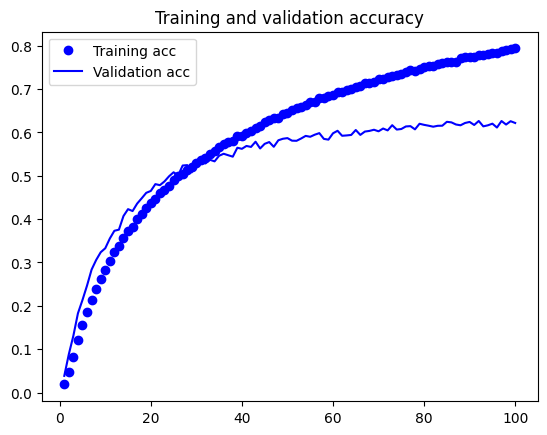

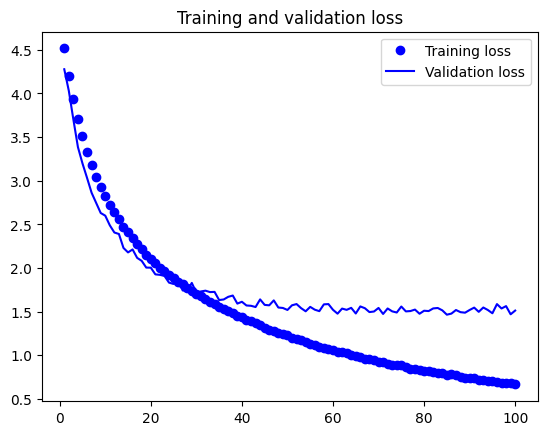

In [35]:
# Visualize training process
training_plot(history_op)

####Rendimiento

In [36]:
scores_op = model_op.evaluate(test_data, test_labels)
TEST_LOSS.append(scores_op[0])
TEST_ACC.append(scores_op[1])
print(f'accuracy on test set: {model_op.metrics_names[1]} of {scores_op[1]*100}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6346 - loss: 1.5027
accuracy on test set: compile_metrics of 63.05000185966492


Con los datos anteriormente descritos se obtienen los siguientes valores:
*   Tiempo de ejecución: ~5317 s.
*   Precisión con los datos de test: ~65%



In [37]:
# Name of all classes in CIFAR-100
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale',
'aquarium' ,'fish', 'ray', 'shark', 'trout',
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
'bottles', 'bowls', 'cans', 'cups', 'plates',
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe',
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
'bear', 'leopard', 'lion', 'tiger', 'wolf',
'bridge', 'castle', 'house', 'road', 'skyscraper',
'cloud', 'forest', 'mountain', 'plain', 'sea',
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
'crab', 'lobster', 'snail', 'spider', 'worm',
'baby', 'boy', 'girl', 'man', 'woman',
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
'maple', 'oak', 'palm', 'pine', 'willow',
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

In [38]:
from sklearn.metrics import confusion_matrix
from numpy import argmax

prediction = []
true_labels = []

pred = model_op.predict(test_data)
print(test_labels.shape[0])
for i in range(test_labels.shape[0]):
  prediction.append(argmax(pred[i]))
  true_labels.append(argmax(test_labels[i]))

cm = confusion_matrix(prediction, true_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
10000


In [39]:
# Calculating f1 score
from sklearn.metrics import f1_score

print(f"f1 score: {f1_score(true_labels, prediction, average='weighted')*100}")

f1 score: 62.46495798543138


#Evolución

A continuación las gráficas correspondientes a la pérdida y precisión con los datos de entrenamiento de los 3 modelos.

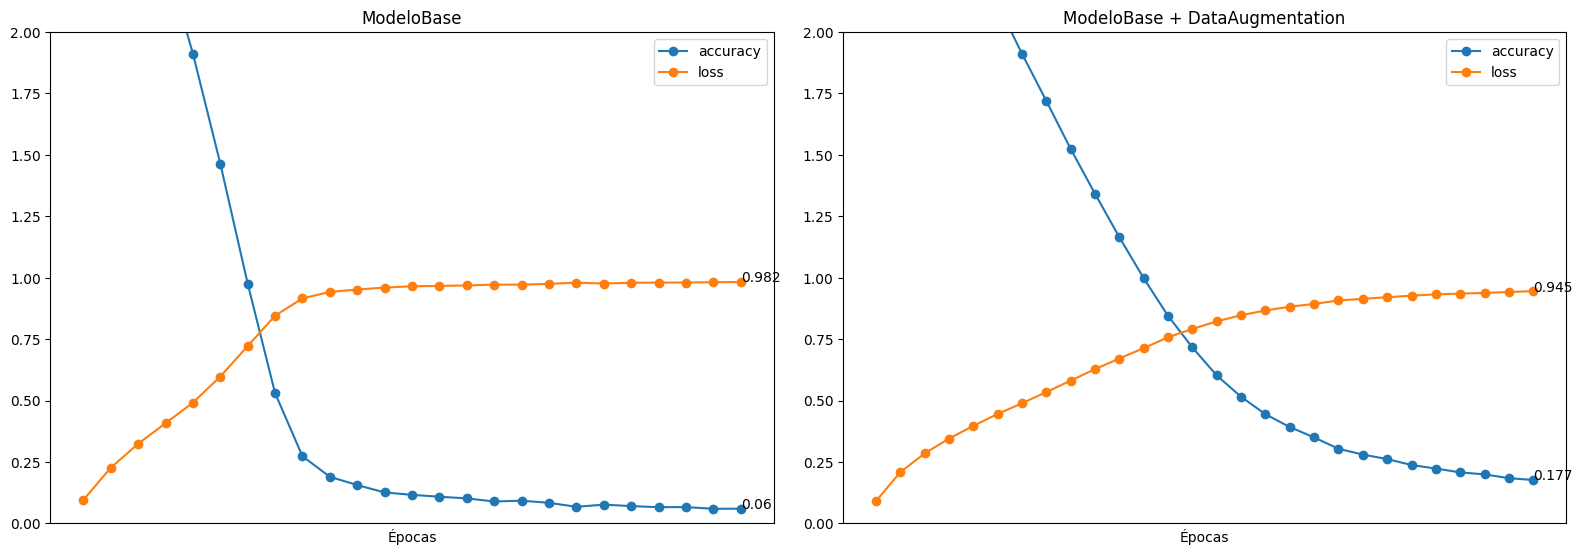

In [44]:
title = ['ModeloBase', 'ModeloBase + DataAugmentation', 'ModeloOptimizado + DataAugmentation']
curvas_aprendizaje(HISTORY[:2], 3, 2, (16,16), title)

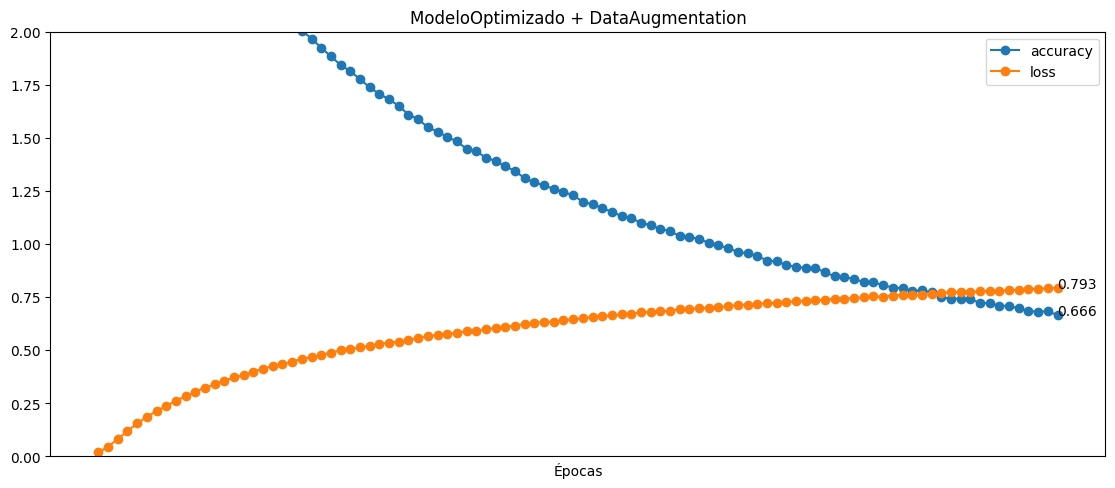

In [45]:
curvas_aprendizaje(HISTORY[2:], 3, 2, (22,14),
                   title[2:])

Se observa como para el modelo base la pérdida y precisión convergen muy rápidamente alcanzando una cota alta con muy pocas épocas. Para el modelo base con data augmentation ambas medidas convergen más lentamente con un número similar de épocas y para el modelo optimizado con data augmentation la convergencia es mucho más suave en un número de épocas mucho mayor. Suavizar la convergencia del modelo se consigue mediante el uso de optimizadores y data augmentation y consigue que el modelo sea capaz de reconocer de manera más óptima las imágenes de validación.

A continuación se añade una gráfica con los tiempos de ejecución de cada modelo.

El indicador de tiempo nos pueda dar una medida de la complejidad de los distintos modelos ya que los 3 han sido ejecutados en las mismas condiciones de capacidad de proceso y recursos. En la tabla anterior se observa que el algoritmo base es el que se ejecuta más rápidamente. El resultado es lógico ya que es el algoritmo más sencillo aunque la salida del mismo es la menos precisa. En el caso 2 el tiempo se incrementa al igual que la precisión. En el caso 3 el tiempo se incrementa de una manera significativa debido a la mayor complejidad del modelo y al aumento de epochs para alcanzar un incremento significativo de la precisión.

Por último se gráfica por medio de un grafico de barras los datos de pérdida y precisión obtenidos sobre los datos de test.

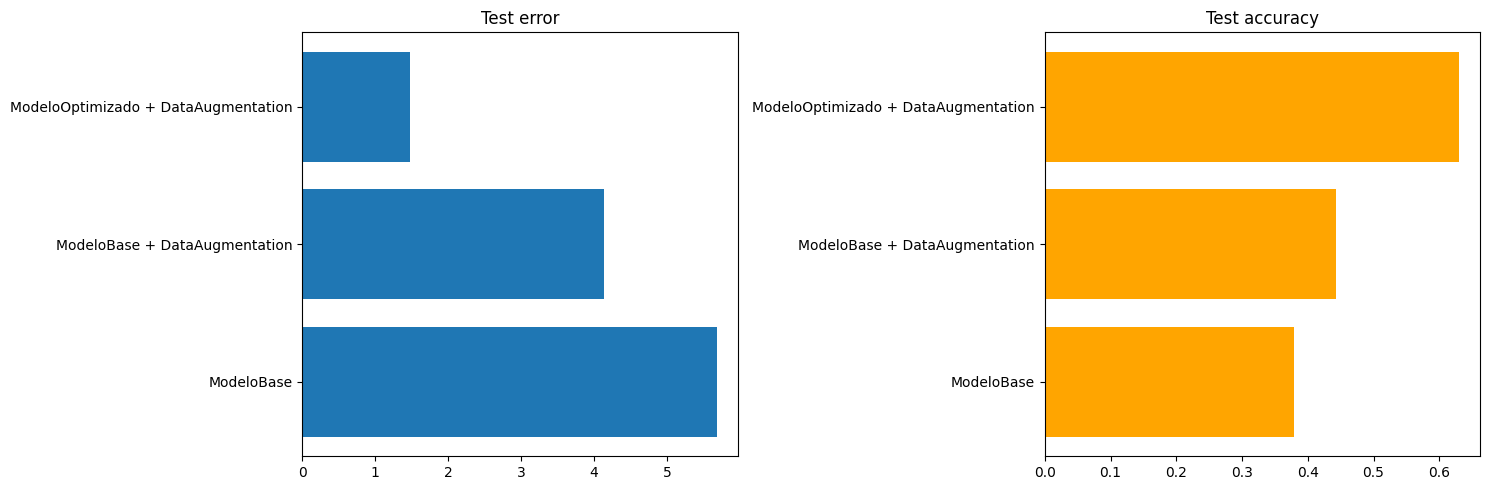

In [42]:
testerror_testacc(TEST_LOSS, TEST_ACC, title, (15, 5))

Si se comparan el modelo base con el modelo base con data agumentation se aprecia como el uso de la técnica de data augmentaton sobre el modelo base produce en la pérdida una mejoría del 27% aprox. y del 7% aprox. en la precisión.
Al comparar el modelo base con data augmentation con el modelo optimizado con data agumentation se observa que el uso de los optimizadores mejoran significativamente el rendimiento del modelo produciendo una mejoría del 66% respecto a la pérdida y del 20% respecto a la precisión.

Remarcar que la mejoría en los datos de test entre el modelo base con data augmentation y el optimizado es posible debido a la eliminación del sobreentrenamiento el cual impedía que el modelo base con data augmentation se entrenara adecuadamante afectando en su rendimiento.